<a href="https://colab.research.google.com/github/Evergarden0101/FS23-Deep-Learning/blob/main/DL_Assignment05_group12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Classification in PyTorch 


For this exercise, we will switch to an implementation in PyTorch. 
The goal of this exercise is to get used to some concepts in PyTorch, such as relying on the `torch.tensor` data structure, implementing the network, the loss functions, the training loop and accuracy computation, which we will apply to binary and categorical classification.

Please make sure that all your variables are compatible with `torch`.
For example, you cannot mix `torch.tensor`s and `numpy.ndarray`s in any part of the code.

## Dataset

We will use two different datasets, the *spambase* dataset https://archive.ics.uci.edu/ml/datasets/spambase for binary classification and the *wine* dataset https://archive.ics.uci.edu/ml/datasets/wine for categorical classification. Both datasets are available on the UCI Machine Learning repository. 
The binary classification dataset contains features extracted from emails, which are classified as either spam or not. 
The categorical classification dataset contains some manually selected features for three different types of wines. 
For the former, the class is provided in the last column of the data file, whereas for the latter, the first index provides class information.

Please run the code block below to download the data files.

In [ ]:
import os
import torch

# download the two dataset files
dataset_files = {
  "spambase.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/",
  "wine.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/"
}
for name, url in dataset_files.items():
  if not os.path.exists(name):
    import urllib.request
    urllib.request.urlretrieve(url+name, name)
    print ("Downloaded datafile", name)

### Task 1: Dataset Loading

The first task deals with the loading of the datasets. 
When training networks in PyTorch, all data needs to be stored as datatype ``torch.tensor``. 
The data should be split between input sets $\mathbf X = [\vec x^{[1]}, \ldots, \vec x^{[N]}]^T \in \mathbb R^{N\times D}$ and targets.
There is **no need to add a bias neuron to the input**, and the transposition of the data matrix is different from what we have seen before.

For the targets, we have to be more careful as there are differences w.r.t. the applied loss function.
For binary classification, we need $\mathbf T = [[t^{[1]}, \ldots, t^{[N]}]]$ to be in dimension $\mathbb R^{N\times1}$ and of type ``torch.float``.
For categorical classification, we only need the class indexes $\vec t = [t^{[1]}, \ldots, t^{[N]}]$ to be in dimension $\mathbb N^N$ and of type ``torch.long``.

Implement a function that returns both the input and the target data for a given dataset

Note:

1. You can use `csv.reader()` to read the dataset, or rely on other methods such as `pandas`.
2. For the wine dataset, subtract the target by `-1` to get the target values in range $\{0, 1, 2\}$.
3. Be aware both datasets are sorted w.r.t. their labels.

In [ ]:
import numpy as np

def dataset(dataset_file="wine.data"):
  # read dataset
  data = []
  with open(dataset_file, 'r') as f:
    for lines in f:
      data.append([float(x) for x in lines.split(",")])

  data = np.array(data)

  print (f"Loaded dataset with {len(data)} samples")
  
  # convert to torch.tensor
  tensor_data = torch.tensor(data, dtype=torch.float32)


  if dataset_file == "wine.data":
    # target is in the first column and needs to be converted to long
    X = tensor_data[:,1:].float()
    T = (tensor_data[:,0] - 1).long()
  else:
    # target is in the last column and needs to be of type float
    X = tensor_data[:,:-1].float()
    T = tensor_data[:,-1].float()
    T = T.reshape(-1,1)
  return X, T

### Test 1: Dataset Check

Test 1 assures the correctness of the data and target dimensions.

1. For the wine dataset, we make sure that the dataset is in the correct dimensions, i.e., $\mathbf X\in \mathbb R^{N\times D}$ and $\mathbf T \in \mathbb N^N$. And all class labels are in the correct range $[0, O-1]$ where $O$ is the number of classes.

2. For the spambase data, we assure that all dimensions are correct and that class labels are in range $\{0, 1\}$.

In [ ]:
X, T = dataset("wine.data")

assert X.shape[1] == 13, X.shape[1]
assert torch.all(T >= 0) and torch.all(T <= 2)
assert T.dtype == torch.long

X, T = dataset("spambase.data")
assert X.shape[1] == 57, X.shape[1]
assert T.shape[1] == 1, T.shape[1]
assert torch.all(T >= 0) and torch.all(T <= 1)
assert T.dtype == torch.float

Loaded dataset with 178 samples
Loaded dataset with 4601 samples


### Task 2: Split Training and Validation Data

The data should be split into 80% for training and 20% for validation. Implement a function that takes the full dataset $(X,T)$ and returns $(X_t, T_t, X_v, T_v)$ accordingly.

Write a function that splits off training and validation samples from a given dataset. What do we need to assure before splitting?

In [ ]:
def split_training_data(X,T,train_percentage=0.8):

  # shuffle the data
  indices = torch.randperm(len(X))
  shuffled_X = X[indices]
  shuffled_T = T[indices]

  # calculate the size of training samples
  train_size = int(train_percentage * len(X))
  # val_size = len(X) - train_size

  # split into 80/20 training/validation
  # X_train, X_val = torch.utils.data.random_split(X, [train_size, val_size])
  # T_train, T_val = torch.utils.data.random_split(T, [train_size, val_size])
  X_train = X[:train_size]
  T_train = T[:train_size]
  X_val = X[train_size:]
  T_val = T[train_size:]

  return X_train, T_train, X_val, T_val

### Task 3: Input Data Standardization

As we have seen last week, the standardization of the data provides many advantages. 
Hence, in this task you should write a function that takes $(X_t,X_v)$ as input and standardizes them by subtracting the mean and dividing by the 
standard deviation of $X_t$, and returning the standardized versions of both. Assure that each input dimension is standardized individually.

Implement a function that standardizes all input data for the training and validation set.
Return the standardized data.

Note:

1. Use `torch.mean()` and `torch.std()` with the correct dimensions.

In [ ]:
def standardize(X_train, X_val):
  # compute statistics
  mean = torch.mean(X_train, dim=0)
  std = torch.std(X_train, dim=0)

  # standardize both X_train and X_val
  X_train = (X_train - mean) / std
  X_val = (X_val - mean) / std

  return X_train, X_val

## Network Implementation

We will use a two-layer fully-connected network with $D$ input neurons, $K$ hidden neurons and $O$ output neurons. 
Depending on the task, $D$ and $O$ need to be selected appropriately, while $K$ is a parameter to play around with. 
In PyTorch, the easiest way to implement a network is by providing the requested sequence of layers to `torch.nn.Sequential`, which will build a network containing the given layers. 
We will use two `torch.nn.Linear` layers and one `torch.nn.Tanh` activation function in between. 
The network will return the logits $\vec z$ for a given input $\vec x$.


### Task 4: Implement Network

Implement a two-layer fully-connected network in PyTorch. 
The given network uses $\tanh$ as activation function, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.

In [ ]:
import torch

def Network(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Linear(D, K),
    torch.nn.Tanh(),
    torch.nn.Linear(K, O)
  )

### Task 5: Accuracy Computation

To monitor the training process, we want to compute the accuracy. 
The function will obtain the logits $\vec z$ extracted from the network and the according target $t$. 
Assure that this function works both for binary and categorical classification. 
How can we identify, which of the two variants is currently required?

Note: you can make use of the following pytorch functions:

1. `torch.mean()` which computes the mean or average of the input tensor.
2. `torch.argmax()` which returns the indices of the maximum values of all elements of the tensor.

In [ ]:
def accuracy(Z, T):
  # check if we have binary or categorical classification
  if Z.shape[-1] == 1:
    # binary classification
    Y = torch.sigmoid(Z)
    Y_pred = torch.where(Y > 0.5, 1, 0)
    return torch.mean((Y_pred == T).float())
  else:
    # categorical classification
    Y = torch.softmax(Z, dim=-1)
    Y_pred = torch.argmax(Y, dim=-1)
    return torch.mean((Y_pred == T).float())

### Test 2: Test Accuracy Function

Test 2 assures the correctness of your accuracy function in both binary and categorical cases. We make sure that the accuracy will compute the correct values.

In [ ]:
# first, test binary classification
ZZ = torch.ones((20,1)) * -5.
ZZ[15:20] = 5
assert(abs(accuracy(ZZ,torch.zeros((20,1))) - 0.75) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones((20,1))) - 0.25) < 1e-8)

# now, test categorical classification with 4 classes
ZZ = torch.ones((20,4)) * -5
ZZ[0:1,0] = 5
ZZ[1:4,1] = 5
ZZ[4:10,2] = 5
ZZ[10:20,3] = 5

assert(abs(accuracy(ZZ,torch.zeros(20)) - 0.05) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones(20)) - 0.15) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones(20)*2) - 0.3) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones(20)*3) - 0.5) < 1e-8)
assert(abs(accuracy(ZZ,torch.tensor((0,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3))) - 1.) < 1e-8)

### Task 6: Training Loop

Implement a function that takes all necessary parameters to run a training on a given dataset.
In this week, we will run gradient descent, i.e., we will train on the whole dataset in each training step, so there is no need to define anything related to batches. 
Select the optimizer to be `torch.optim.SGD`. 

Implement a training loop over 10'000 epochs with a learning rate of $\eta=0.1$. 
Make sure that you train on the training data only, and **not** on the validation data.
In each loop, compute and store the training loss, training accuracy, validation loss and validation accuracy. 
At the end, return the lists of these values.

Note:

1. When storing accuracy or loss values in a list, make sure to convert the to float via `v.item()`.

In [ ]:
def train(model, X_train, T_train, X_val, T_val, loss_fn, learning_rate=0.1, num_epochs=10000):
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # collect loss and accuracy values
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(num_epochs):
    optimizer.zero_grad()

    # train on training set
    # ... compute network output on training data
    Z_train = model(X_train)
    # ... compute loss from network output and target data
    t_loss = loss_fn(Z_train, T_train)
    t_loss.backward()
    # ... perform parameter update
    optimizer.step()

    # ... remember loss
    train_loss.append(t_loss.item())
    # ... compute training set accuracy
    t_acc = accuracy(Z_train, T_train)
    train_acc.append(t_acc.item())

    # test on validation data
    with torch.no_grad():
      # ... compute network output on validation data
      Z_val = model(X_val)
      # ... compute loss from network output and target data
      v_loss = loss_fn(Z_val, T_val)
      # ... remember loss
      val_loss.append(v_loss.item())
      # ... compute validation set accuracy
      v_acc = accuracy(Z_val, T_val)
      val_acc.append(v_acc.item())

  # return the four lists of losses and accuracies
  return train_loss, train_acc, val_loss, val_acc

## Training and Evaluation

Finally, we want to train our network on our data and plot the accuracy and loss values that were obtained through the epochs. 
Exemplary plots can be found in the exercise slides.


### Task 7: Plotting Function

Implement a function that takes four lists containing the training loss, the training accuracy, the validation loss and the validation accuracy and plot them into two plots. 
The first plot should contain the loss values for both training and validation. The second plot should contain the according accuracy values.

Note:

1. You might need to convert remaining `torch.tensor` values to `float`, lists, or `numpy.nadrray` for plotting.

In [ ]:
from matplotlib import pyplot
def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.legend()

### Task 8: Binary Classification


1. Load the data for binary classification, using the ``"spambase.data"`` file.
2. Split the data into training and validation sets.
3. Standardize both training and validation input data using the function from Task 3.
4. Instantiate a network with the correct number of input neurons, a reasonable number of $K$ hidden neurons and one output neuron.

Which loss function do we need for this task?

Train the network with our data for 10'000 epochs and plot the training and validation accuracies and losses.

Loaded dataset with 4601 samples


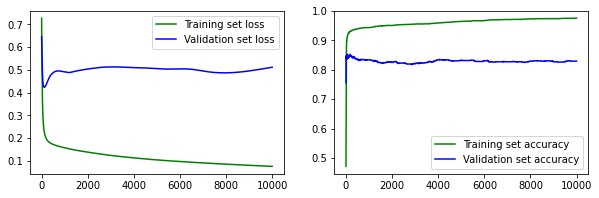

In [ ]:
# define loss function
loss = torch.nn.BCEWithLogitsLoss()
# loss = torch.nn.CrossEntropyLoss()
# load dataset
X, T = dataset(dataset_file="spambase.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X,T,train_percentage=0.8)
# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
net = Network(X.shape[1], 10, 1)

# train network on our data
# results = ...
train_loss, train_acc, val_loss, val_acc = train(net, X_train, T_train, X_val, T_val, loss, learning_rate=0.1, num_epochs=10000)
# plot the results
plot(train_loss, train_acc, val_loss, val_acc)

### Task 9: Categorical Classification

Perform the same tasks with the ``"wine.data"`` dataset for categorical classification. 
How many input and output neurons do we need?
Change the number of input, hidden, and output neurons accordingly.

Select the appropriate loss function for categorical classification.
Which loss function will we need this time?

How many hidden neurons will we need to get 100% training set accuracy?

Loaded dataset with 178 samples


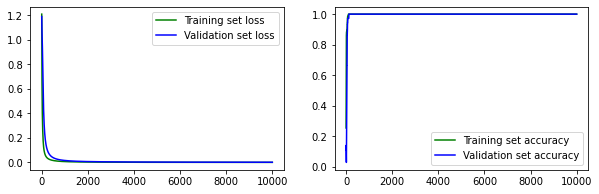

In [ ]:
# define loss function
loss = torch.nn.CrossEntropyLoss()
# load dataset
X, T = dataset(dataset_file="wine.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X,T,train_percentage=0.8)
# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
net = Network(X.shape[1], 10, 3)

# train network on our data
# results = ...
train_loss, train_acc, val_loss, val_acc = train(net, X_train, T_train, X_val, T_val, loss, learning_rate=0.1, num_epochs=10000)
# plot the results
plot(train_loss, train_acc, val_loss, val_acc)